In [4]:
import sys, pickle
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse
from sklearn.feature_selection import mutual_info_regression
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from temp_tf_load import *
sys.path.append('../../hde')
import warnings
warnings.filterwarnings('ignore')
from hde import HDE, analysis

/home/mikejones/scratch-midway2/anaconda3/bin/python3.7


Using TensorFlow backend.


In [116]:
# stores msm information 
class seqObj:
    
    def __init__(self, seq, temp, ticks, state_list, nstates, nmodes, minflux=3e-6, reduced=True):
        
        self.ticks = ticks
        self.state_list = state_list
        self.nstates = nstates
        self.nmodes = nmodes
        self.minflux = minflux
        
        #set msm directory:
        if reduced:
            self.meta_dir= f'./MSMs/{seq}_dist_reduced_{temp}K_40-250000-55_micro-200_macro-{nstates}_lag-12_srvlag-12/'
        else:
            self.meta_dir= f'./MSMs/{seq}_dist_{temp}K_40-250000-190_micro-200_macro-{nstates}_lag-12_srvlag-12/'
            
        # load pre-run from directory
        self.cluster_hde = pickle.load(open(self.meta_dir + 'hde_cluster.pkl', 'rb'))
        self.cluster_tica = pickle.load(open(self.meta_dir + 'tica_cluster.pkl', 'rb'))

        self.msm_hde = pickle.load(open(self.meta_dir + 'msm_hde.pkl', 'rb'))
        self.msm_tica = pickle.load(open(self.meta_dir + 'msm_tica.pkl', 'rb'))

        self.hde_coords = pickle.load(open(self.meta_dir +'hde_coords.pkl', 'rb'))
        self.tica_coords = pickle.load(open(self.meta_dir +'tica_coords.pkl', 'rb'))

        self.dtraj_tica = self.cluster_tica.dtrajs
        self.dtraj_hde = self.cluster_hde.dtrajs
        
        self.nits, self.lags = 8, 30 #50
        self.its_tica = pyemma.msm.its(self.dtraj_tica, lags=self.lags, nits=self.nits)
        self.its_hde = pyemma.msm.its(self.dtraj_hde, lags=self.lags, nits=self.nits)   #errors='bayes
        
        # calculate transition matrix
        pcca = self.msm_hde.pcca(self.nstates)
        T = pcca.coarse_grained_transition_matrix.copy()
        T[T < 0] *= 0
        self.T = T/T.sum(axis=1)[:, np.newaxis]

# collect all sequence objects into a dict
seq_dict = {}
reduced = True

seq_dict['AT-all'] =  seqObj(seq='AT-all', temp=309, reduced = reduced,
                      ticks = ['A', 'T', 'A', 'T', 'A', 'T', 'A', 'T', 'A', 'T'],
                      state_list=['3S4', '5S4', '3S2', '5S2', 'H', 'D'],
                      nstates= 6, nmodes = 5)

seq_dict['GC-end'] =  seqObj(seq='GC-end', temp=317, reduced = reduced,
                      ticks = ['G', 'A', 'T', 'A', 'T', 'A', 'T', 'A', 'T', 'C'],
                      state_list=['5S4', '3S2', '5S2', 'D', 'H'],
                      nstates= 5, nmodes = 5)

seq_dict['GC-mix'] = seqObj(seq='GC-mix', temp=324, reduced = reduced,
                      ticks = ['A', 'T', 'G', 'A', 'T', 'A', 'T', 'G', 'A', 'T'],
                      state_list=['H', 'D'], 
                      nstates= 2, nmodes = 2)

seq_dict['GC-core'] = seqObj(seq='GC-core', temp=324, reduced = reduced,
                      ticks = ['A', 'T', 'A', 'T', 'G', 'C', 'A', 'T', 'A', 'T'],
                      state_list=['F4', 'H', 'D'], 
                      nstates= 3, nmodes = 3)

### Compare all sequences using shared set of macrostates


AT-all States: 
state	p_stat		p_std		G/kT
		 -6
3S4	1.20e-03   ±	7.67e-05	6.72
		 -5
5S4	3.62e-03   ±	7.86e-05	5.62
		 -4
3S2	1.57e-02   ±	3.19e-04	4.16
		 -2
5S2	7.88e-02   ±	2.41e-04	2.54
		 0
H	4.15e-01   ±	3.07e-04	0.88
		 0
D	4.85e-01   ±	6.29e-04	0.72

GC-end States: 
state	p_stat		p_std		G/kT
		 -9
5S4	5.35e-05   ±	5.54e-06	9.84
		 -7
3S2	4.04e-04   ±	2.92e-05	7.81
		 -6
5S2	1.18e-03   ±	6.20e-05	6.74
		 0
D	4.26e-01   ±	6.00e-04	0.85
		 0
H	5.72e-01   ±	5.91e-04	0.56

GC-core States: 
state	p_stat		p_std		G/kT
		 -5
F4	2.77e-03   ±	2.28e-05	5.89
		 0
H	4.53e-01   ±	4.66e-04	0.79
		 0
D	5.45e-01   ±	4.69e-04	0.61

GC-mix States: 
state	p_stat		p_std		G/kT
		 0
H	4.43e-01   ±	5.09e-04	0.81
		 0
D	5.57e-01   ±	5.09e-04	0.59


"# plot free energy table\naxes[1, 0].set_title('Free energy by state', fontweight='bold')\nax = axes[1, 0]\nax.axis('tight')\nax.axis('off')\ndyn_table = ax.table(meta_list, loc='center', rowLoc='center')\ndyn_table.set_fontsize(34)\ndyn_table.scale(1, 5)"

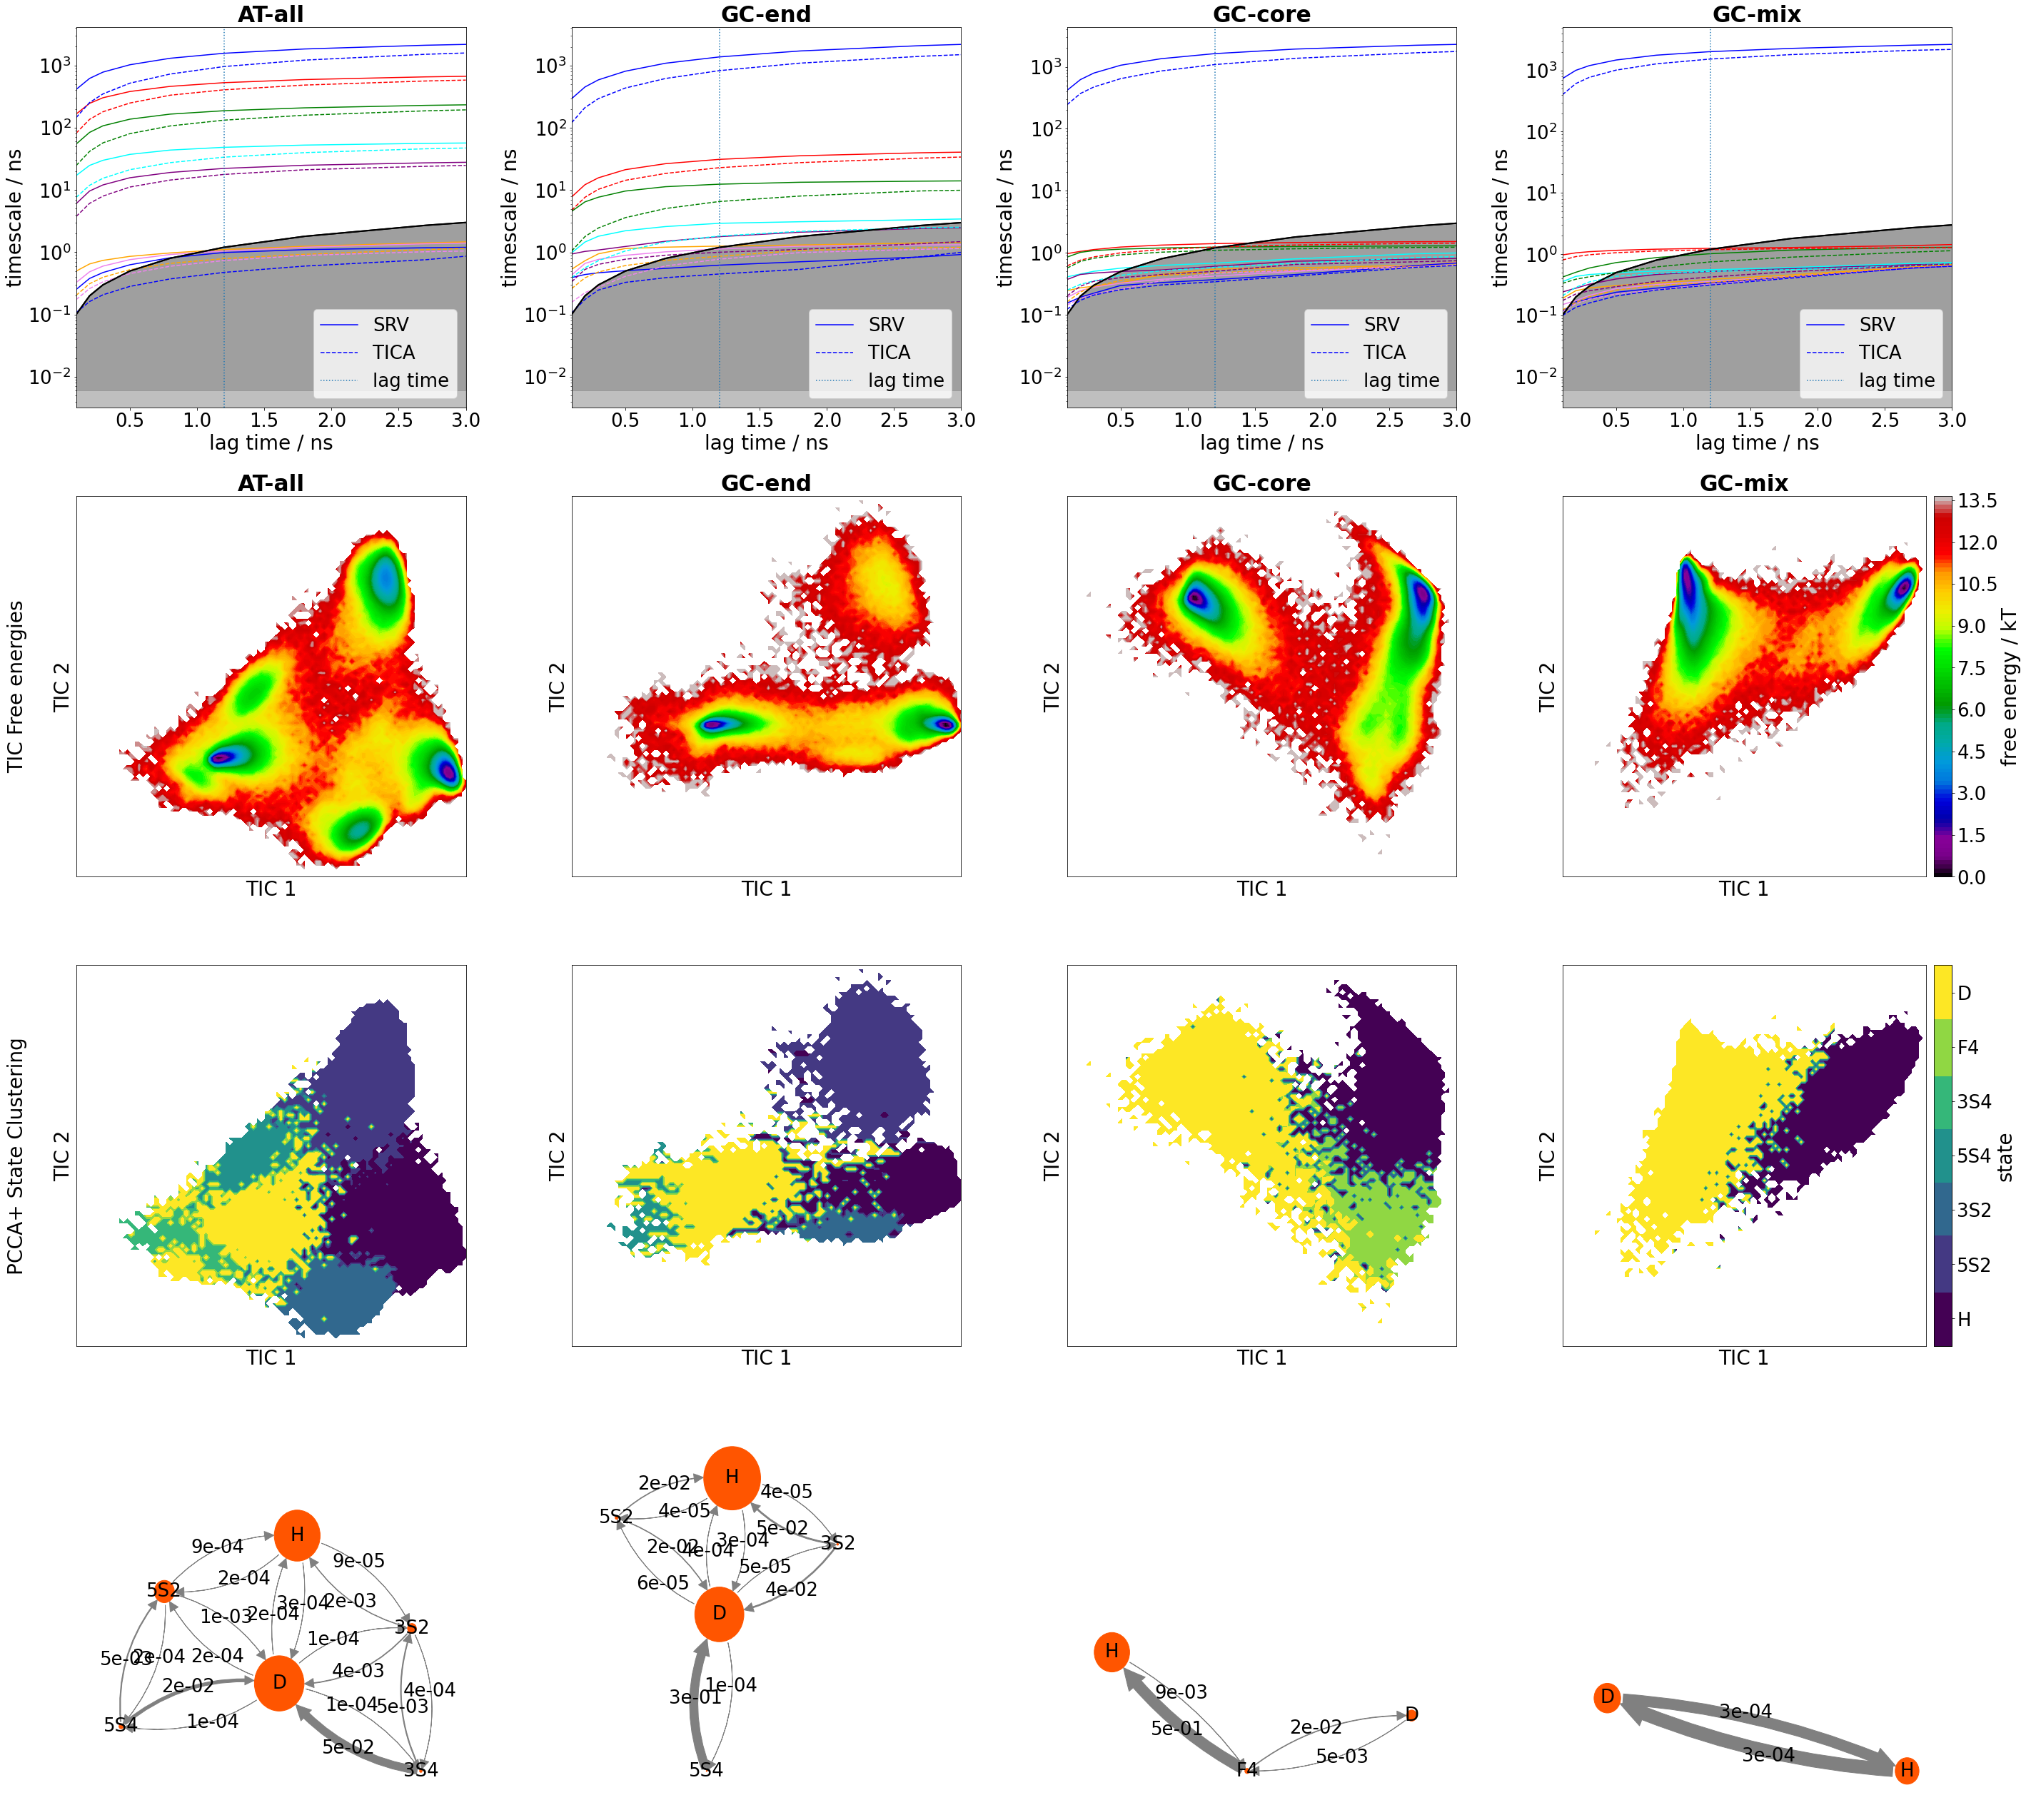

In [119]:
# make collection of plots

plt.rcParams.update({'font.size': 26})
plt.rc('axes', labelsize=28)
fig, axes = plt.subplots(4, 4, figsize=(40, 36))

tic_x, tic_y = 0, 1
p_skip = 1

seq_list = ['AT-all', 'GC-end', 'GC-core', 'GC-mix']
all_states = ['H', '5S2', '3S2', '5S4', '3S4','F4', 'D']

def change_meta_idx(org_states, meta_traj_hde):
    '''reindex for shared state colorbar'''
    
    new_meta = np.zeros(meta_traj_hde.shape)-1
    for i, meta in enumerate(org_states):
        new_idx = all_states.index(meta)
        rep_idx = np.where(meta_traj_hde==i)
        new_meta[rep_idx] = new_idx
        
    # add all states for consistency on legend
    new_meta[:len(all_states)] = [i for i in range(len(all_states))]
        
    return new_meta
    
for i, seq in enumerate(seq_list):
    
    # get sequence specific path and params
    seq_obj = seq_dict[seq]
    meta_dir = seq_obj.meta_dir
    nstates = seq_obj.nstates
    state_list = seq_obj.state_list
    dtraj_hde = seq_obj.dtraj_hde
    
    # load msm and meta_traj data for each sequence
    msm_hde = seq_obj.msm_hde
    meta_traj_hde = msm_hde.metastable_assignments[np.concatenate(dtraj_hde)] #pickle.load(open(meta_dir +'hde_meta_states.pkl', 'rb'))  #
    meta_traj_hde = change_meta_idx(state_list, meta_traj_hde)
    #pcca = msm_hde.pcca(nstates)
    
    # print free energies for each pcca+ state
    print(f'\n{seq} States: ')
    #print('state\tconformation\tπ\t\tG/kT')
    print(f'state\tp_stat\t\tp_std\t\tG/kT')
    for j, s in enumerate(msm_hde.metastable_sets):

        p_list = []
        for sample in msm_hde._samples:
            p_list.append(sample.stationary_distribution[s].sum())

        p_mean, p_std = np.mean(p_list), np.std(p_list)
        dec = int(np.log(p_mean))
        
        print('\t\t', dec)
        print(f'{state_list[j]}\t{p_mean:.2e}   \u00B1\t{p_std:.2e}\t{-np.log(p_mean):.2f}')
        
        #p = msm_hde.pi[s].sum()
        #print('{}\t{}\t{:f}\t{:f}'.format(j, state_list[j], p, -np.log(p)))
        
    # plot implied timescles
    dt, lag = 0.1, 12  # 100 ps per frame
    ax = axes[0, i]
    ax.set_title(seq, fontweight='bold')
    #ax.set_title('Leading implied timescales')
    
    
    pyemma.plots.plot_implied_timescales(seq_obj.its_hde, units='ns', dt=dt, ax=ax, linestyle='solid', label='SRV')
    pyemma.plots.plot_implied_timescales(seq_obj.its_tica, units='ns', dt=dt, ax=ax, linestyle='dashed', label='TICA')
    ax.axvline(lag*dt, linestyle='dotted', label = 'lag time')

    h, l = ax.get_legend_handles_labels()
    h1, l1 = [h[0], h[seq_obj.nits], h[-1]], [l[0], l[seq_obj.nits], l[-1]]
    ax.legend(h1, l1)

    # load tica coords for visualization
    tica_c = np.concatenate(seq_obj.tica_coords)
    hde_c = np.concatenate(seq_obj.hde_coords)

    # plot free energy in the first two tica 
    ax = axes[1, i]
    divider = make_axes_locatable(axes[1, 3])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cax.set_yticks([])
    cax.set_xticks([])
    ax.set_title(seq, fontweight='bold')

    # only plot colormap for last sequence
    if i==3:
        pyemma.plots.plot_free_energy(
            *tica_c[:, :2].T,
            weights=np.concatenate(msm_hde.trajectory_weights()),
            ax=ax,
            cax=cax, 
            legacy=False)
    else:
        pyemma.plots.plot_free_energy(
            *tica_c[:, :2].T,
            weights=np.concatenate(msm_hde.trajectory_weights()),
            ax=ax,
            cbar=False,
            legacy=False)

    if i == 0:   ax.set_ylabel('TIC Free energies\n\nTIC 2')
    else:        ax.set_ylabel('TIC 2')
    ax.set_xlabel('TIC 1')
    #ax.set_title(seq, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

    # plot SRV-MSM metastable states on first two TICA coords
    ax = axes[2, i]
    divider = make_axes_locatable(axes[2, 3])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cax.set_yticks([])
    cax.set_xticks([])
    
    if i==3:
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_c[:, [tic_x, tic_y]][::p_skip].T, meta_traj_hde[::p_skip], 
            ax=ax,
            #cmap='rainbow',
            cax=cax,
            )
        misc['cbar'].set_ticklabels([name for name in all_states])
    else:
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_c[:, [tic_x, tic_y]][::p_skip].T, meta_traj_hde[::p_skip], 
            ax=ax,
            #cmap='rainbow',
            cbar=False)

    #misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i) for i in range(nstates)])
    #misc['cbar'].set_ticklabels([name for name in state_list])
    
    if i == 0:   ax.set_ylabel('PCCA+ State Clustering\n\nTIC 2')
    else:        ax.set_ylabel('TIC 2')
    ax.set_xlabel('TIC 1')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title('SRV-MSM metastable states', fontweight='bold')
    
    # plot transition probabilities between states
    ax = axes[3, i]
    pyemma.plots.plot_markov_model(seq_obj.T, minflux=seq_obj.minflux*2, arrow_curvature=1.5, 
                                              state_labels=state_list,  figpadding=0.15, ax = ax)
                                            #state_scale=.5, state_sizes= np.array(state_sizes)

fig.tight_layout()
plt.savefig(f'../paper_figs/all_FE_and_states.pdf', dpi=300, bbox_inches='tight')


'''# plot free energy table
axes[1, 0].set_title('Free energy by state', fontweight='bold')
ax = axes[1, 0]
ax.axis('tight')
ax.axis('off')
dyn_table = ax.table(meta_list, loc='center', rowLoc='center')
dyn_table.set_fontsize(34)
dyn_table.scale(1, 5)'''


### Generate transition diagram for each sequence

AT-all [4.767481377694812, 5.873652839652237, 7.330001966061552, 8.975147891738972, 10.632911840798519, 10.79178066805007]
GC-end [1.664709555151643, 3.6897229842044115, 4.83597927565906, 10.660365950024024, 10.954247718223284]
GC-core [5.623258186181972, 10.721842267614939, 10.903896328108742]
GC-mix [10.70139683894573, 10.92561727022039]


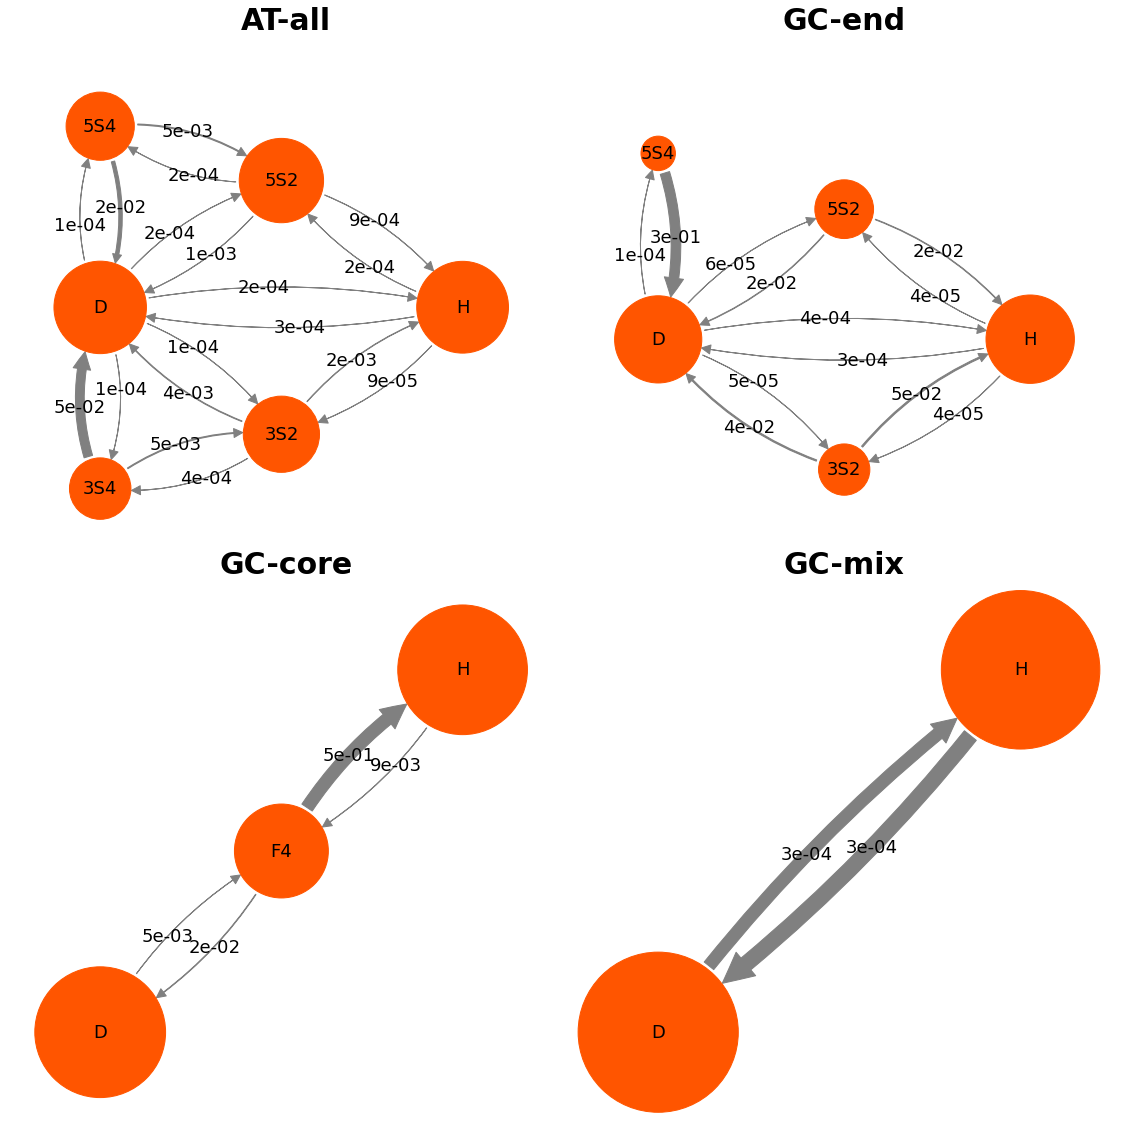

In [120]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

# keep consistent state positions
'''pos_dict = {'D':[0, 0], 
            'H':[1, 1], 
            'F4': [.5, .5], 
            '5S2': [.5, 1], 
            '3S2': [1, .5],
            '5S4': [0, .63], 
            '3S4': [.63, 0]}'''
            
# optimize visualization by sequence
shift_dict = {'H':[2, 0.001], 
            'D':[0, 0],  
            '5S2': [1, .7], 
            '3S2': [1, -.7],
            '5S4': [0, 1], 
            '3S4': [0, -1]}

fray_dict = {'D':[0, 0], 
            'H':[1, 1], 
            'F4': [.5, .5]}


for si, seq in enumerate(['AT-all', 'GC-end', 'GC-core', 'GC-mix']):

    # specify sequence object
    #seq = 'GC-end'
    seq_obj = seq_dict[seq]

    # access transition matri
    msm_hde= seq_obj.msm_hde
    T = seq_obj.T
    T[T < 0] *= 0
    T = T/T.sum(axis=1)[:, np.newaxis]

    # translate state list into a position list 
    state_list= seq_obj.state_list
    
    if seq in ['AT-all', 'GC-end']:
        pos_list = np.array([shift_dict[state] for state in state_list])
    else:
        pos_list = np.array([fray_dict[state] for state in state_list])
    #print(np.round(T, 7))

    # scale disk size by log of stationary probability:
    pnorm = 100000 #20000
    state_sizes = []
    for i, s in enumerate(msm_hde.metastable_sets):
        p = msm_hde.pi[s].sum()
        state_sizes.append(np.log(p*pnorm))

    print(seq, state_sizes)
    ax = axes[si//2, si%2]
    ax.set_title(seq, fontweight='bold', fontsize=30)
    fig, pos = pyemma.plots.plot_markov_model(T, minflux=seq_obj.minflux, 
                                          arrow_curvature=1.2, 
                                          state_labels=state_list, 
                                          #state_scale=5, 
                                          state_sizes= np.array(state_sizes), 
                                          figpadding=0.25, 
                                          pos=pos_list,
                                          arrow_scale = 1.2, 
                                          #arrow_labels = None,
                                          ax = ax)
    #ax.set_xlim((-1, 3))
    #ax.set_ylim((-1, 3))
    
plt.subplots_adjust(hspace=0.0)
plt.subplots_adjust(wspace=0.0)


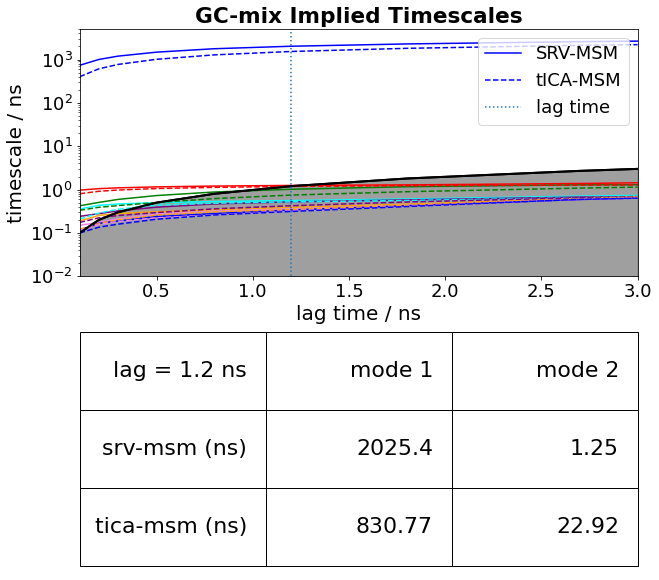

In [121]:
# collection of plot reflecting the dynamics

plt.rc('axes', labelsize=20)
fig, axes =plt.subplots(2, 1,figsize=(10, 10))

#plot implied timescales
ax = axes[0]
pyemma.plots.plot_implied_timescales(seq_obj.its_hde, units='ns', dt=.1, ax=ax, linestyle='solid', label='SRV-MSM')
pyemma.plots.plot_implied_timescales(seq_obj.its_tica, units='ns', dt=.1, ax=ax, linestyle='dashed', label='tICA-MSM')
ax.set_title(f'{seq} Implied Timescales', fontweight='bold')
ax.set_ylim(0.01, 5000)

ax.axvline(lag*dt, linestyle='dotted', label = 'lag time')
h, l = ax.get_legend_handles_labels()
h1, l1 = [h[0], h[seq_obj.nits], h[-1]], [l[0], l[seq_obj.nits], l[-1]]
ax.legend(h1, l1)

# gather hde and tica timescales for each mode
ts = 0.1 #ns
hde_times, tica_times = msm_hde.timescales(seq_obj.nmodes), msm_tica.timescales(seq_obj.nmodes)
dyn_list = [[f'lag = {np.round(lag*ts, 1)} ns', 'srv-msm (ns)', 'tica-msm (ns)']]
meta_list = [['state', 'conformation', 'π', 'G/kT']]
for m in range(seq_obj.nmodes):
    row = [f'mode {m+1}', np.round(ts*hde_times[m], 2), np.round(ts*tica_times[m], 2)]
    dyn_list.append(row)
    
# switch table orientation
dyn_list_T = list(map(list, zip(*dyn_list)))

# plot timescales table
ax = axes[1]
ax.axis('tight')
ax.axis('off')
dyn_table = ax.table(dyn_list_T, loc='center', rowLoc='center')
dyn_table.set_fontsize(34)
dyn_table.scale(1, 6.5)



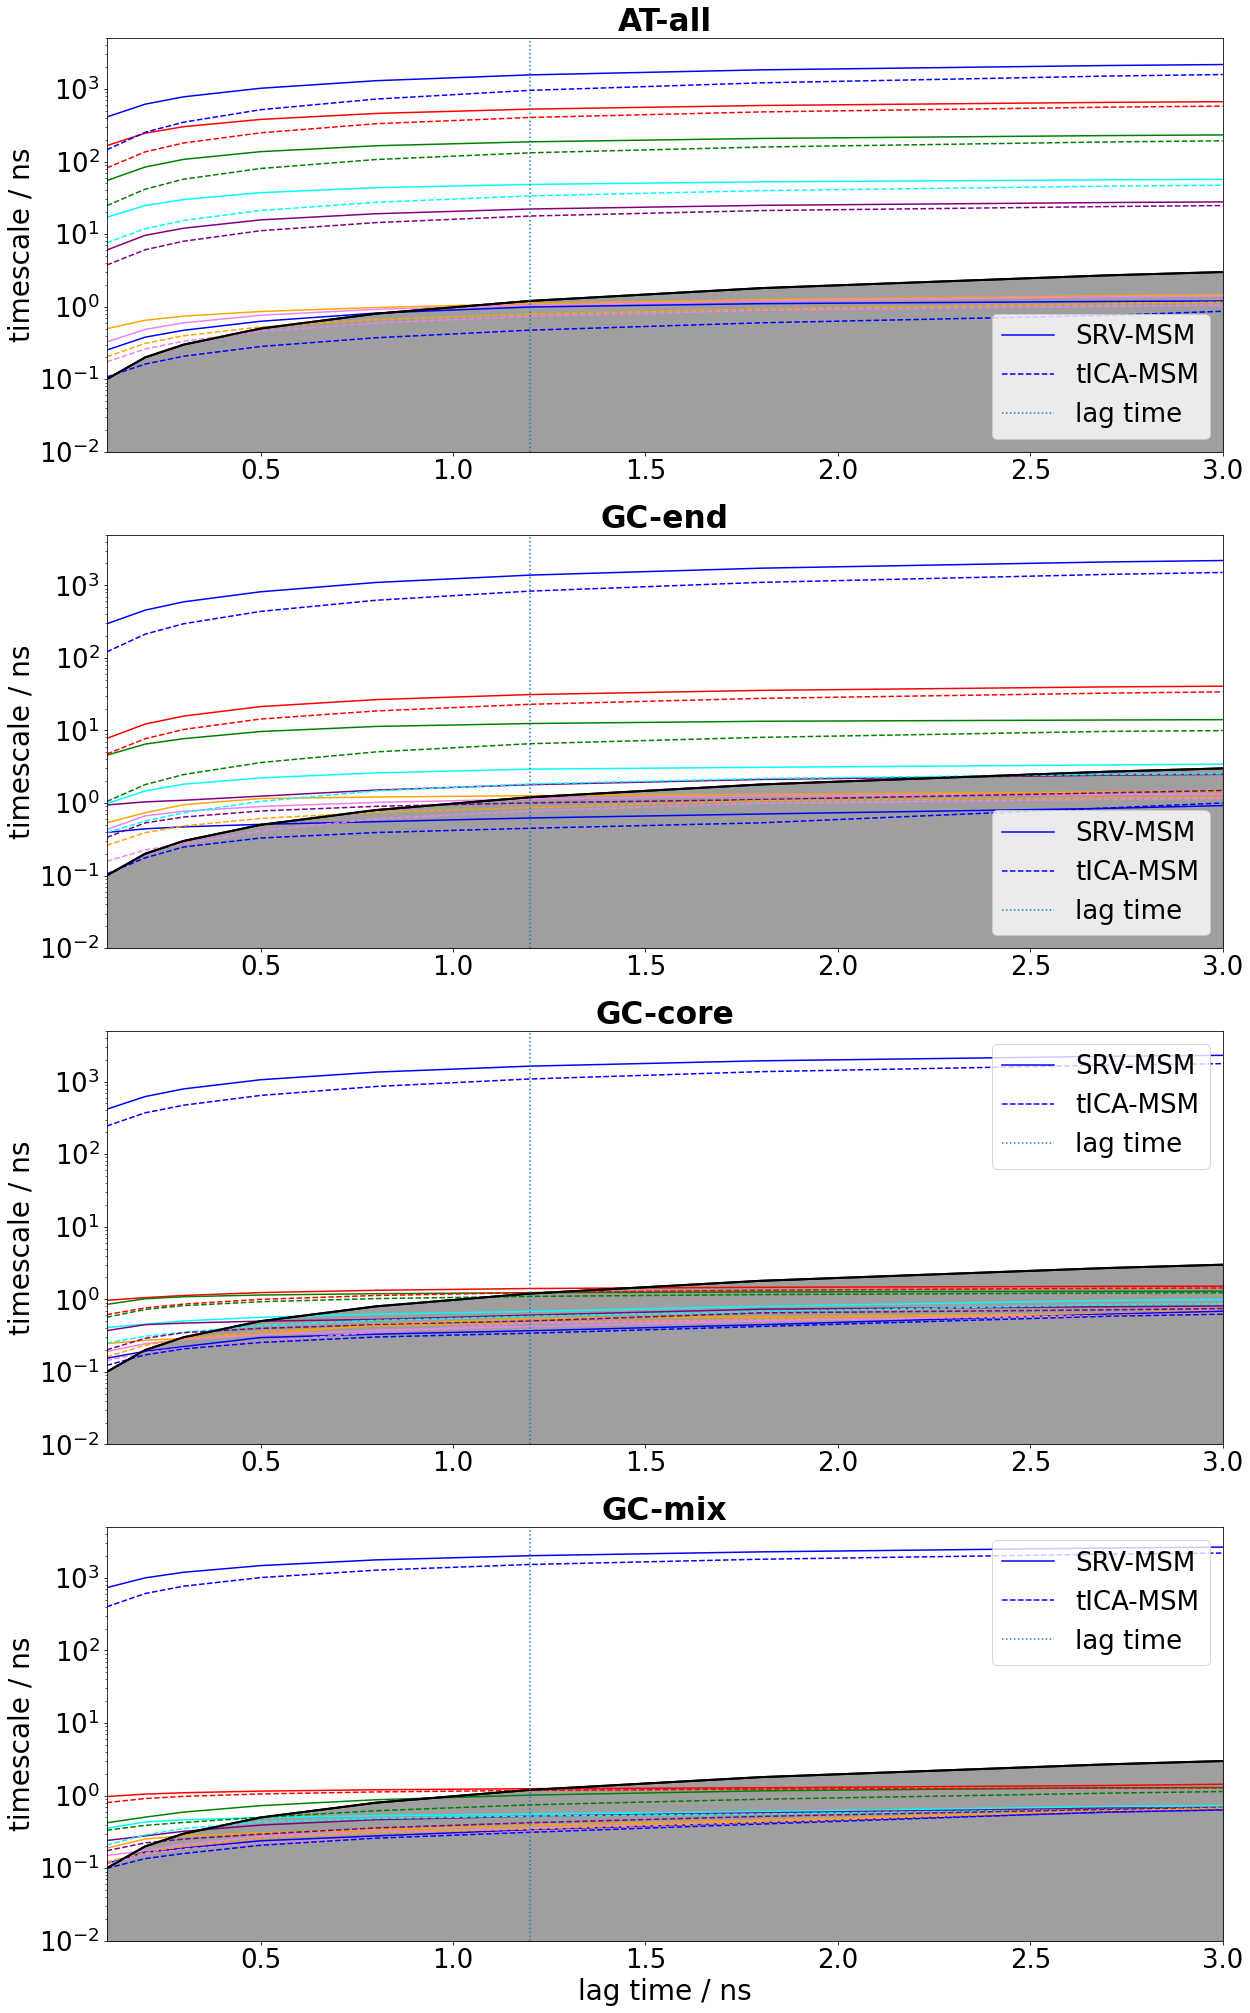

In [122]:
## plot all other implied timescales

plt.rcParams.update({'font.size': 26})
plt.rc('axes', labelsize=28)
fig, axes = plt.subplots(4, figsize=(20, 35))

for i, seq in enumerate(['AT-all', 'GC-end', 'GC-core', 'GC-mix']):
    
    # get sequence specific path and params
    seq_obj = seq_dict[seq]
        
    # plot implied timescles
    dt, lag = 0.1, 12  # 100 ps per frame
    ax = axes[i]
    ax.set_title(seq, fontweight='bold')
    ax.set_ylim(0.01, 5000)
    #ax.set_title('Leading implied timescales')
    
    
    pyemma.plots.plot_implied_timescales(seq_obj.its_hde, units='ns', dt=dt, ax=ax, linestyle='solid', label='SRV-MSM')
    pyemma.plots.plot_implied_timescales(seq_obj.its_tica, units='ns', dt=dt, ax=ax, linestyle='dashed', label='tICA-MSM')
    ax.axvline(lag*dt, linestyle='dotted', label = 'lag time')
    if i < 3:   ax.set_xlabel('')

    h, l = ax.get_legend_handles_labels()
    h1, l1 = [h[0], h[seq_obj.nits], h[-1]], [l[0], l[seq_obj.nits], l[-1]]
    ax.legend(h1, l1)

plt.subplots_adjust()